## Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

## Checking for 'cuda'

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
device

device(type='cuda')

## Visualizing the data count

In [8]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

In [9]:
import os

def count_files_and_images(directory):
    class_counts = {}
    total_images = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            file_count = len(os.listdir(class_path))
            class_counts[class_name] = file_count
            total_images += file_count

    return class_counts, total_images

train_directory = train_dir
test_directory = test_dir

train_class_counts, total_train_images = count_files_and_images(train_directory)
test_class_counts, total_test_images = count_files_and_images(test_directory)

# Print the results
print("Train Directory:")
print("Class Counts:", train_class_counts)
print("Total Train Images:", total_train_images)

print("\nTest Directory:")
print("Class Counts:", test_class_counts)
print("Total Test Images:", total_test_images)

Train Directory:
Class Counts: {'pani puri': 2223, 'selroti': 2205, 'gajar ko halwa': 2160, 'lassi': 1992, 'biryani': 2226, 'kodo ko roti': 1596, 'laphing': 2187, 'buff curry': 1197, 'phini roti': 693, 'yomari': 2115, 'sekuwa': 1656, 'dalbhat': 1953, 'bhatmas sadeko': 1469, 'gundruk': 1326, 'chatamari': 1430, 'sisnu soup': 1029, 'chhoila': 1560, 'chhurpi': 1898, 'khaja set': 1788, 'khapse': 2097, 'dhido': 1890, 'thukpa': 1764, 'kakro ko achar': 1274, 'kheer': 1866, 'dhau(yogurt)': 1534, 'samosa': 1908, 'jeri(jalebi)': 2214, 'sukuti': 1625, 'chow mein': 1908, 'kwati': 1729, 'bara': 1848, 'chicken curry': 2376, 'momos': 2250, 'aalu chop': 2178}
Total Train Images: 61164

Test Directory:
Class Counts: {'pani puri': 62, 'selroti': 61, 'gajar ko halwa': 60, 'lassi': 83, 'biryani': 92, 'kodo ko roti': 19, 'laphing': 61, 'buff curry': 14, 'phini roti': 8, 'yomari': 58, 'sekuwa': 46, 'dalbhat': 54, 'bhatmas sadeko': 28, 'gundruk': 25, 'chatamari': 28, 'sisnu soup': 12, 'chhoila': 30, 'chhurpi'

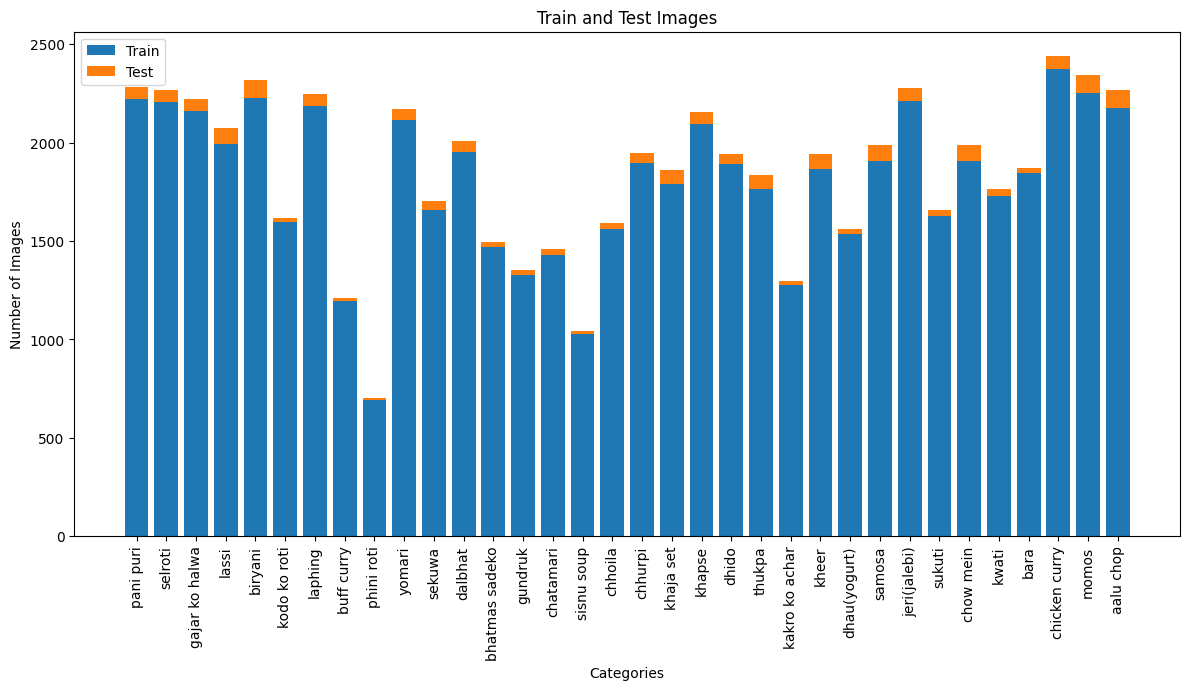

In [10]:
# Data
categories = [i for i in train_class_counts.keys()]
train_values = [i for i in train_class_counts.values()]
test_values = [i for i in test_class_counts.values()]

# Create bar graph
plt.figure(figsize=(12,6))
plt.bar(categories, train_values, label='Train')
plt.bar(categories, test_values, bottom=train_values, label='Test')

# Add title and labels
plt.title('Train and Test Images')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.tight_layout()

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Show the graph
plt.show()

Test data seems too small but it is not. It is because train data are augmented.

## Hyperparameters

In [80]:
batch_size = 32
learning_rate = 0.001
num_epochs = 30

num_classes = 34

# Image size
img_height = 128
img_width = 128

## Data preprocessing

In [81]:
transform = transforms.Compose(
    [transforms.Resize((img_height, img_width)),
     transforms.ToTensor(),  # To convert to tensor with compatible data type i.e., float32
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # To normalize image

train_set = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

In [82]:
classes = train_loader.dataset.classes
print(classes)

['aalu chop', 'bara', 'bhatmas sadeko', 'biryani', 'buff curry', 'chatamari', 'chhoila', 'chhurpi', 'chicken curry', 'chow mein', 'dalbhat', 'dhau(yogurt)', 'dhido', 'gajar ko halwa', 'gundruk', 'jeri(jalebi)', 'kakro ko achar', 'khaja set', 'khapse', 'kheer', 'kodo ko roti', 'kwati', 'laphing', 'lassi', 'momos', 'pani puri', 'phini roti', 'samosa', 'sekuwa', 'selroti', 'sisnu soup', 'sukuti', 'thukpa', 'yomari']


## Data Visualization

In [91]:
# Function to show images
def imshow(ax, img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[label])
    ax.axis('off')  # Hide axes

In [92]:
writer = SummaryWriter(log_dir = '/content/runs/Nepali_Food_Classification')
# Can be viewed by using code: 'tensorboard --logdir=runs'

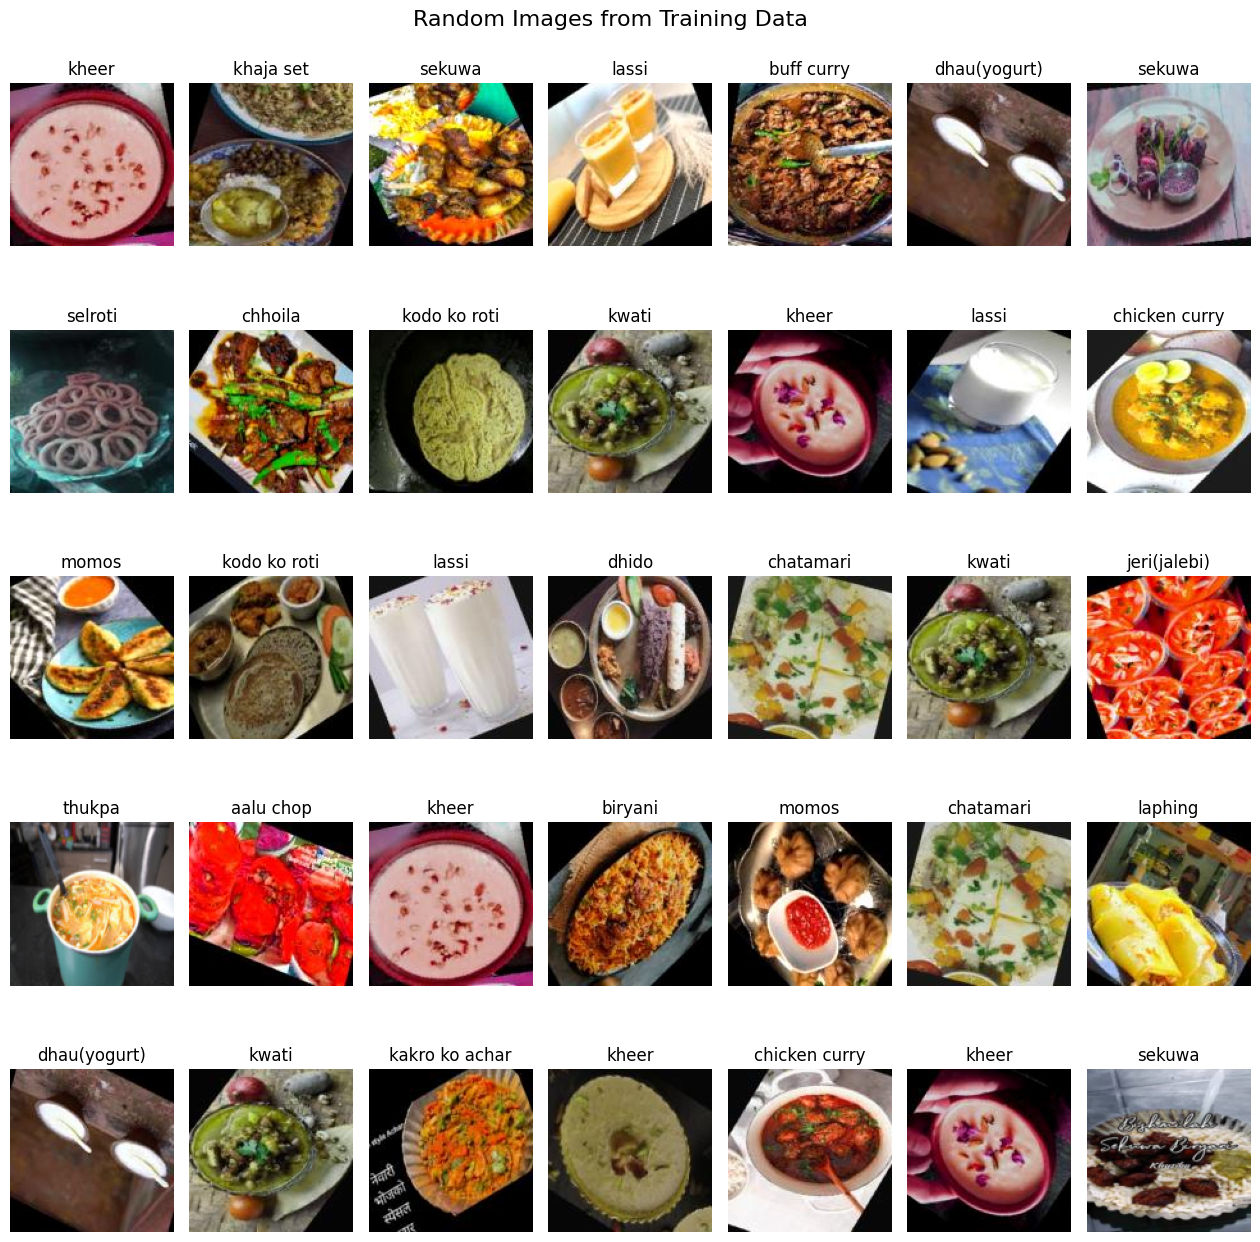

In [93]:
# Get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

img_grid = torchvision.utils.make_grid(images)
writer.add_image('food_images', img_grid)

# Plot the images in a grid
fig, axes = plt.subplots(5, 7, figsize=(16, 16))
fig.suptitle('Random Images from Training Data', fontsize=16, y=0.9)
plt.subplots_adjust(wspace=0.1, hspace=0)

for i in range(5):
    for j in range(7):
        index = np.random.randint(batch_size)
        ax = axes[i, j]
        imshow(ax, images[index], labels[index])
        ax.axis('off')

plt.show()

In [94]:
dataloaders = {'train' : train_loader,
               'test' : test_loader}

## Defining the model

In [95]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        """
        This function initializes the layers for the CNN model
        """
        super(CNNModel, self).__init__()

        # parameters for conv layers
        filter_dim = 3
        in_channels = [3, 16, 32]
        out_channels = [16, 32, 64]

        # parameters for dense layers
        dense_in_features = [32*32*64, 32*64]
        dense_out_features = [32*64,  num_classes]

        # initializing all the layers
        self.c1 = nn.Conv2d(in_channels[0], out_channels[0], filter_dim, padding='same')
        self.c2 = nn.Conv2d(in_channels[1], out_channels[1], filter_dim, padding='same')
        self.m1 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.25)
        self.c3 = nn.Conv2d(in_channels[2], out_channels[2], filter_dim, padding='same')
        self.m2 = nn.MaxPool2d(2)
        self.d1 = nn.Linear(dense_in_features[0], dense_out_features[0])
        self.d2 = nn.Linear(dense_in_features[1], dense_out_features[1])

    def forward(self, x):
        """
        This function performs convolutions, relu, max_pooling, dropout,
        reshape and dense operations on the input to the model.

        Parameters
        ------------
        x : tensor, float32
        Input image to the model

        Returns
        ------------
        x : tensor, float32
        output from the last layer

        """
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.dropout(x)
        x = self.m1(x)
        x = F.relu(self.c3(x))
        x = self.m2(x)
        x = x.view(-1, 32*32*64)
        x = self.d1(x)
        x = F.relu(x)
        x = self.d2(x)
        return x

In [96]:
model = CNNModel(num_classes).to(device)

In [97]:
model.parameters

<bound method Module.parameters of CNNModel(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (m1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (c3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (m2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d1): Linear(in_features=65536, out_features=2048, bias=True)
  (d2): Linear(in_features=2048, out_features=34, bias=True)
)>

In [98]:
img_data = images.to(device)
writer.add_graph(model, img_data)

## Training the model

In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [100]:
#Initialize lists to store training and validation metrics
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

best_val_acc = 0.0

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 30)

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0
        total_samples = 0

        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.set_grad_enabled(phase == phase):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            if (i+1)%100==0:
                print('=', end="")

        epoch_loss = running_loss / total_samples
        epoch_acc = corrects.double() / total_samples

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics in history lists
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_loss_history.append(epoch_loss)
        else:
            val_acc_history.append(epoch_acc)
            val_loss_history.append(epoch_loss)

        # Save the model if it has the best validation accuracy
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_weights = model.state_dict()

Epoch 1/30
------------------------------
=========Train Loss: 2.9340 Acc: 0.1538
Test Loss: 2.6195 Acc: 0.2333
Epoch 2/30
------------------------------
=========Train Loss: 2.4280 Acc: 0.2802
Test Loss: 2.3643 Acc: 0.2938
Epoch 3/30
------------------------------
=========Train Loss: 1.6158 Acc: 0.5107
Test Loss: 2.4321 Acc: 0.3185
Epoch 4/30
------------------------------
=========Train Loss: 0.6267 Acc: 0.8063
Test Loss: 3.2607 Acc: 0.3007
Epoch 5/30
------------------------------
=

KeyboardInterrupt: 

In [ ]:
acc = [a.to('cpu') for a in train_acc_history]
val_acc = [v.to('cpu') for v in val_acc_history]

loss = train_loss_history[:]
val_loss = val_loss_history[:]

epochs_range = list(range(num_epochs))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving the model

In [ ]:
torch.save(best_model_weights, 'model.pth')